In [80]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import os
import glob
from scipy.io import wavfile
import librosa
import librosa.display
import torch
import torchaudio ## (I updated my pip to pip 3.11 for this because of some compatibility problem)
from torchaudio import transforms 


Data Augmentation because we have a small data set

1. Spectrogram Augmentation
   

    1.1 Frequency and Time Masking 
         
        The following code will produce one dataset of one random Frequency and Time Masking for each spectrogram, but we can use several such data set. The number to be used can be determined using Cross validation. 
    
    

In [81]:
##load data
load_fp = '../../data/processed_data/specgram_db.npy'
save_fp = '../../data/processed_data/specgram_aug_Fretim_mask.npy'
spec_load = np.load(load_fp)

spec_db = []
for i in range(spec_load.shape[0]):
    unpadded_indice = np.argmax(spec_load[i][0] == -1)
    #print(unpadded_indice)
    unpadded_array = spec_load[i][:, :unpadded_indice]
    spec_db.append(unpadded_array)

try augment for one sample

In [82]:
##used function from https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    n_mels, n_steps = spec.shape ##I deleted the dimension channel compared to the original code
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [83]:
original = spec_db[5]
original = torch.from_numpy(original)##transfer a numpy array to tensor
aug_spec = spectro_augment(original) 
aug_spec = np.array(aug_spec)## transfer the result back to a numpy array

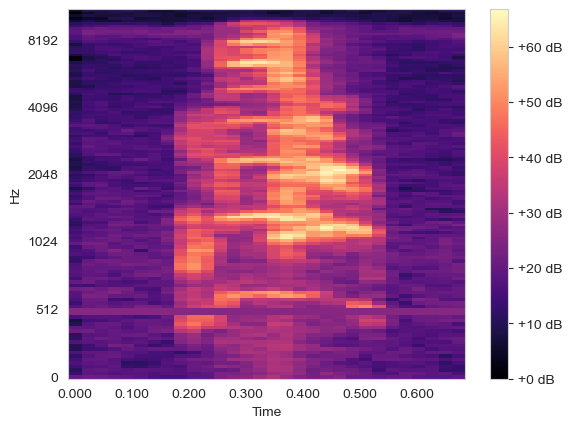

In [84]:
librosa.display.specshow(aug_spec, x_axis='time',y_axis='mel') ##
plt.colorbar(format='%+2.0f dB')


Store Frequency/Time masking data for the whole dataset

In [85]:
arrs = []
for i in range(len(spec_db)):
    spec_tensor = torch.from_numpy(spec_db[i])
    spec_FreTmask = np.array(spectro_augment(spec_tensor))
    arrs.append(spec_FreTmask)
    

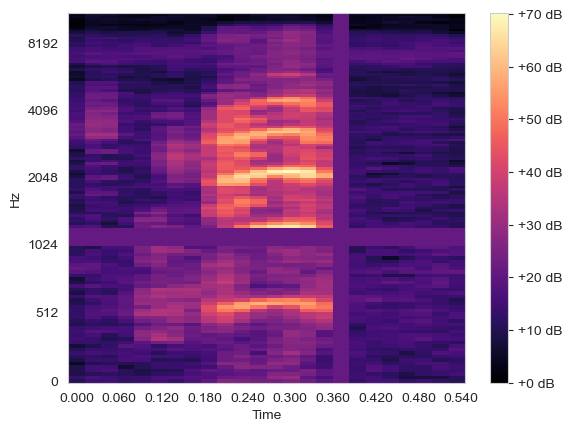

In [90]:
librosa.display.specshow(arrs[23], x_axis='time',y_axis='mel') ##
plt.colorbar(format='%+2.0f dB')


In [91]:
shapes0 = [_.shape[0] for _ in arrs]
max_shape0 = np.max(shapes0) ##this is a bit unnecessary because this dimension is the same for all the data, just trying to be consistent with the other dimension
shapes1 = [_.shape[1] for _ in arrs]
max_shape1 = np.max(shapes1)+1 ##I added one for this just to make sure all rows are added 0 (just to make recover easier)
spec_FreTmask_data = []
for i in range(len(arrs)):
    spec_FreTmask_data.append(np.pad(arrs[i], ((0, 0), (max_shape0-arrs[i].shape[0], max_shape1 - arrs[i].shape[1])), mode='constant',constant_values=-1))

spec_FreTmask_data = np.array(spec_FreTmask_data) ##transfered it to numpy array
    

In [92]:
np.save(save_fp,spec_FreTmask_data)


In [94]:
spec_FreTmask_data.shape

(440, 128, 64)